In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


# Extract Data and read csv file into a DataFrame

In [50]:

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [51]:
df = pd.read_csv(csv_path)

# Plot Data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe478778710>],
      dtype=object)

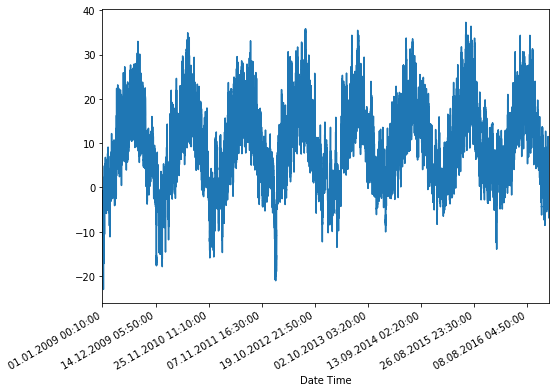

In [52]:

plot_df = df['T (degC)']
plot_df.index = df['Date Time']
plot_df.plot(subplots=True)


In [ ]:
plot_df_2years = plot_df[:105261]

In [ ]:
plot_df_2years.plot(subplots=True)

In [ ]:
plot_df_30.tail()

## To Do: What's KDE Plot

In [ ]:
# What's kde plot???
plot_df.plot(kind='kde')

# Extracting Temperature to a Dataframe

In [ ]:
df_s = pd.DataFrame({'Date Time':plot_df.index, 'Temperature':plot_df.values})
df_s['Date Time'] = pd.to_datetime(df_s['Date Time'])
df_s = df_s.set_index('Date Time')
df_s.head(100)

In [ ]:
df_s_30 = pd.DataFrame({'Date Time':plot_df_30.index, 'Temperature':plot_df_30.values})
df_s_30['Date Time'] = pd.to_datetime(df_s_30['Date Time'])
df_s_30 = df_s_30.set_index('Date Time')
df_s_30.head(100)

# Decomposition of timeseries into Trend, Seasonality and Residuals

In [ ]:
# Need to write frequency calculation
result = seasonal_decompose(df_s, freq=52560)
result.plot()
plt.show()

# Histogram Plot

In [ ]:
df_s.hist()

# Check if Time Series is Stationary

In [ ]:
def test_stationarity(df_s):
    X = df_s.values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return [{'Mean-1': mean1,'Mean-2': mean2}, {'Variance-1':var1,'Variance-2':var2}]
    

In [ ]:
results = test_stationarity(df_s)
print("Simple Results:")
print("Mean for first 1/2 of data: {}, Mean for Second 1/2 of data: {}".
      format(results[0].get('Mean-1'), results[0].get('Mean-2')))
print("Variance for first 1/2 of data: {}, Mean for Second 1/2 of data: {}".
      format(results[1].get('Variance-1'), results[1].get('Variance-2')))

# Dickey Fuller test for stationarity check

#### Todo: Actually the P value is less than 0.05 implies we can reject null hypothesis and consider that timeseries is stationary. Here timeseries is not stationary but p value is less than 0.05. Don't know why!!

# Dickey Fuller test using statstools function

In [ ]:
#define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag =1)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [ ]:
data = df_s['Temperature']
data = data.values.flatten()
adf_test(data)

# Dickey Fuller test by writing the function from scratch

In [ ]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

def adf(ts):
    """
    Augmented Dickey-Fuller unit root test
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Get the dimension of the array
    nobs = ts.shape[0]
    
    # We use 1 as maximum lag in our calculations
    maxlag = 1
    
    # Calculate the discrete difference
    tsdiff = np.diff(ts)
    
    # Create a 2d array of lags, trim invalid observations on both sides
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in')
    # Get dimension of the array
    nobs = tsdall.shape[0] 
    
    # replace 0 xdiff with level of x
    tsdall[:, 0] = ts[-nobs - 1:-1]  
    tsdshort = tsdiff[-nobs:]
    
    # Calculate the linear regression using an ordinary least squares model    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
    
    # Get approx p-value from a precomputed table (from stattools)
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return pvalue

In [ ]:
adf(df_s['Temperature'])

# Removing Non Stationarity

In [ ]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [ ]:
def difference_using_shift(dataset,interval):
    return dataset - dataset.shift(interval)
    

In [ ]:
def perform_seasonal_decomposition(series_data):
    series_data = series_data.dropna()
    df_s = pd.DataFrame({'Date Time':series_data.index, 'Temperature':series_data.values})
    df_s['Date Time'] = pd.to_datetime(df_s['Date Time'])
    df_s = df_s.set_index('Date Time')
    result = seasonal_decompose(df_s, freq=52560)
    result.plot()
    plt.show()

In [ ]:
# It's taking a long time for somereason
plot_df = difference(df['T (degC)'])
plot_df.index = df['Date Time'].values[1:]
perform_seasonal_decomposition(plot_df)

# Using Differencing

In [ ]:
plot_df = difference_using_shift(df['T (degC)'],1)
plot_df.index = df['Date Time']
perform_seasonal_decomposition(plot_df)
print(plot_df.shape)

# 30 days Data

In [ ]:
# Why 4320?
# 6 observations per hour. 24 hours per day => 24*6 = 144 observations per day => 144*30 per 30 days => 4320
day_30_data = plot_df.iloc[1:4320]

In [ ]:
TRAIN_SPLIT = 4316

In [ ]:
train, test = day_30_data[1:TRAIN_SPLIT+1], day_30_data[TRAIN_SPLIT:]

# AR Model

In [ ]:
from statsmodels.tsa.ar_model import AR
model = AR(train.values)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start = len(train), end = len(train)+len(test)-1)
print('Predictions:')
print('-----------------')
print(predictions)
print(test)

In [ ]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

# MA Model

In [ ]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train.values, order=(0, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start = len(train), end = len(train)+len(test)-1)
print('Predictions:')
print('-----------------')
print(predictions)

In [ ]:
model_fit.summary()

# Data visualisation using AR and MA models

In [ ]:
# One year of data => 365*144 => 52560 nearly
temp_df = plot_df[1: 52557]

In [ ]:
def plot_data(results):
    df_t = pd.DataFrame({'index':pd.to_datetime(temp_df.index).strftime('%d-%m-%Y'),'Actual temp':temp_df})
    df_p = pd.DataFrame({'index':pd.to_datetime(results.fittedvalues.index).strftime('%d-%m-%Y'),'Predicted temp':results.fittedvalues})
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    df_t.plot(y=["Actual temp"], ax=ax,color='blue')
    df_p.plot(y=["Predicted temp"], ax=ax2, ls="--",color='red')


    ax.legend(loc=1)
    ax2.legend(loc=2)
    fig.autofmt_xdate()
    plt.show()

In [ ]:
model = ARIMA(temp_df,order=(0,1,2))
results_ma = model.fit(disp=-1)
temp_df = temp_df[1:len(temp_df)]
# Residual sum of squares
print('Residual Sum of squares: {}'.format(sum((results_ma.fittedvalues-temp_df)**2)))

In [ ]:
plot_data(results_ma)

In [ ]:
model = ARIMA(temp_df,order=(2,1,0))
results_ar = model.fit(disp=-1)
temp_rss = (results_ar.fittedvalues-temp_df).dropna()

print('Residual Sum of squares: {}'.format(sum(temp_rss**2)))
plot_data(results_ar)

# ARIMA Model

## Step-1: Find the 'd' parameter- Order of differencing

In [ ]:
plot_df_30.diff().dropna().values

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(plot_df_30.values); axes[0].set_title('Original Series',fontsize=9)
# 1st Differencing
axes[1].plot(plot_df_30.diff().values); axes[1].set_title('1st Order Differencing',fontsize=9)
axes[2].plot(plot_df_30.diff().diff().values); axes[2].set_title('2nd Order Differencing',fontsize=9)
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True)
plot_acf(plot_df_30, ax=axes[0])
plot_acf(plot_df_30.diff().dropna(), ax=axes[1])
plot_acf(plot_df_30.diff().diff().dropna(), ax=axes[2])
plt.show()

## Finding the order of AR term

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(plot_df_30.diff().values); axes[0].set_title('1st Differencing')
plot_pacf(plot_df_30.diff().dropna().values, alpha = 0.05, ax=axes[1])
plt.tight_layout()
plt.show()

# Finding the order of MA term

Just like we used PACF for finding the order of AR term, for MA term we use ACF Plot. 
Basically for MA term we need to know how many lagged terms need to be incoporated in the model- which ACF plot clearly shows

In [ ]:
model = ARIMA(df_s.Temperature, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 2,1,2 ARIMA Model
model = ARIMA(df_s.Temperature.diff().dropna(), order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
plot_df_30.plot(subplots=True)

In [ ]:
TRAIN_SPLIT = 3311
train_s = plot_df_30[1:TRAIN_SPLIT]
test_s = plot_df_30[TRAIN_SPLIT:]

In [ ]:
train_s.plot(subplots=True)

In [ ]:
train_s

In [ ]:
# Build Model
model = ARIMA(plot_df_2years, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  

In [ ]:
print(fitted.summary())

In [ ]:
fc, se, conf = fitted.forecast(144, alpha=0.05)  # 95% conf

In [ ]:
fc_series = pd.Series(fc, index= plot_df[105261:105261+144].index)

In [ ]:
lower_series = pd.Series(conf[:, 0], index=test_s.index)

In [ ]:
upper_series = pd.Series(conf[:, 1], index=test_s.index)

In [ ]:
plot_df[105261:105261+144].plot()

In [ ]:
fc_series.plot(subplots = True)

In [ ]:
test_s.plot(subplots=True)

In [ ]:
plt.plot(fc_series)

In [ ]:

# Plot
plt.plot(train_s, label='training')
plt.plot(test_s, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
plot_df_30

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(plot_df_2years, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


In [ ]:
plot_df[105261:118221].plot()

In [ ]:
n_periods = 12960

fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

In [ ]:
index_of_fc = np.arange(len(plot_df_2years), len(plot_df_2years)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)

In [ ]:
fc_series.plot()

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

# Holt's method

In [ ]:
df_s.iloc[:52560*7+120]

In [ ]:
df_s.iloc[52560*7+120:]

In [ ]:
df_s.Temperature[52560*7+120:]

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fit1 = Holt(df_s.Temperature[:52560*7+120],damped = True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast1 = fit1.forecast(52511)
real_val = df_s.Temperature[52560*7+120:].values
plt.figure(figsize=(16,8))
plt.plot(df_s.Temperature[:52560*7+120], label='Train')
plt.plot(df_s.Temperature[52560*7+120:], label='Test')
df_result = pd.DataFrame(data = fcast1.values, index = df_s.Temperature[52560*7+120:].index, columns = ['Temperature'])
plt.plot(df_result.Temperature, label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [ ]:
fit1 = ExponentialSmoothing(df_s.Temperature[:52557*6+120] ,seasonal_periods=7056 ,trend='add', seasonal='add',damped = True).fit()
fcast1 = fit1.forecast(52557)
plt.figure(figsize=(16,8))
plt.plot(df_s.Temperature[:52557*7+120], label='Train')
plt.plot(df_s.Temperature[52557*7+120:], label='Test')
df_result = pd.DataFrame(data = fcast1.values[:52532], index = df_s.Temperature[52557*7+120:].index, columns = ['Temperature'])
plt.plot(df_result.Temperature, label='Holt_winters')
plt.legend(loc='best')
plt.show()

# TBATS

In [53]:
from tbats import TBATS, BATS
# Fit the model
sample_monthly = plot_df[0:len(plot_df.values):144]
y_to_train = sample_monthly.iloc[:(len(sample_monthly)-365)]
y_to_test = sample_monthly.iloc[(len(sample_monthly)-365):] # last year for testing

In [26]:
estimator = TBATS(seasonal_periods=(7,365.25))
model = estimator.fit(y_to_train)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)

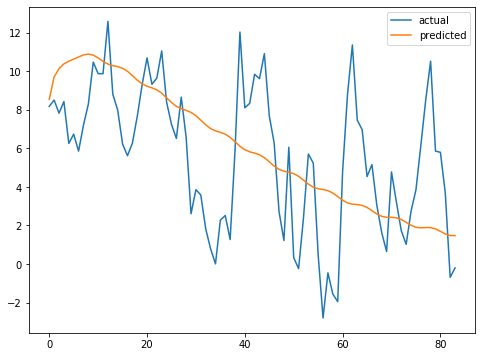

In [28]:
plt.plot(y_to_test.values,label = 'actual')
plt.plot(y_forecast,label = 'predicted')
plt.legend()
plt.show()

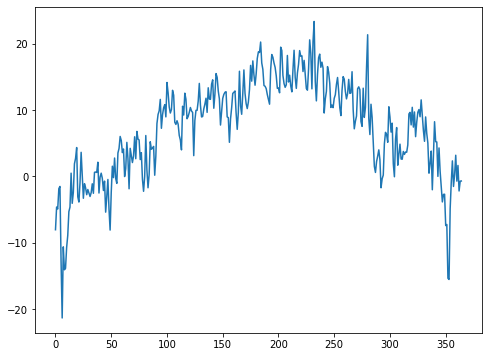

In [46]:
plt.plot(sample_monthly[:365].values)

In [ ]:
from pmdarima import auto_arima
arima_model = auto_arima(y_to_train, seasonal=True, m=12)
y_arima_forecast = arima_model.predict(n_periods=365)

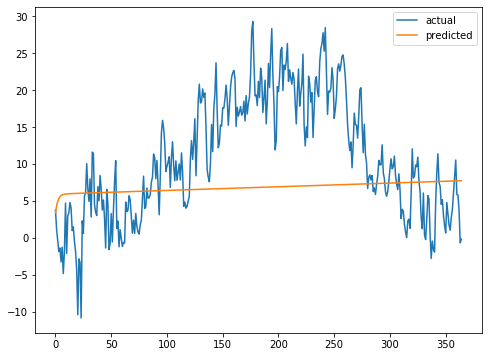

In [77]:
plt.plot(y_to_test.values,label = 'actual')
plt.plot(y_arima_forecast,label = 'predicted')
plt.legend()
plt.show()

In [110]:

df = pd.read_csv('portland-oregon-average-monthly-.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[114], inplace=True)
df.drop(df.index[114], inplace=True)

In [111]:
import datetime
from dateutil.relativedelta import relativedelta
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [112]:
df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)

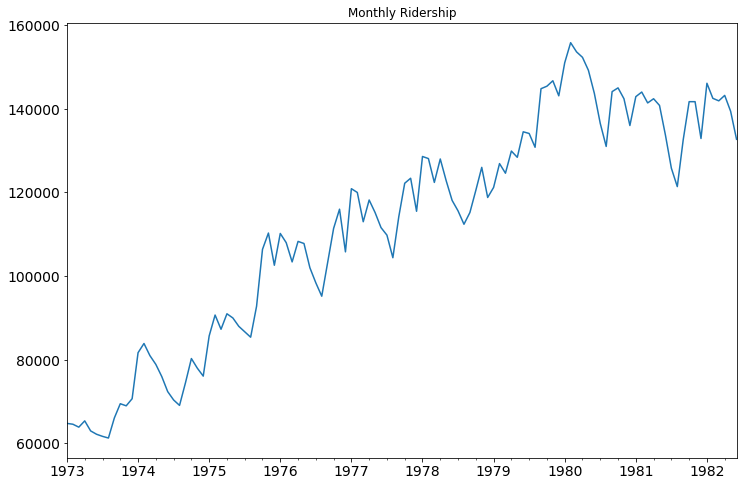

In [113]:
df.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
plt.savefig('month_ridership.png', bbox_inches='tight')

<Figure size 576x432 with 0 Axes>

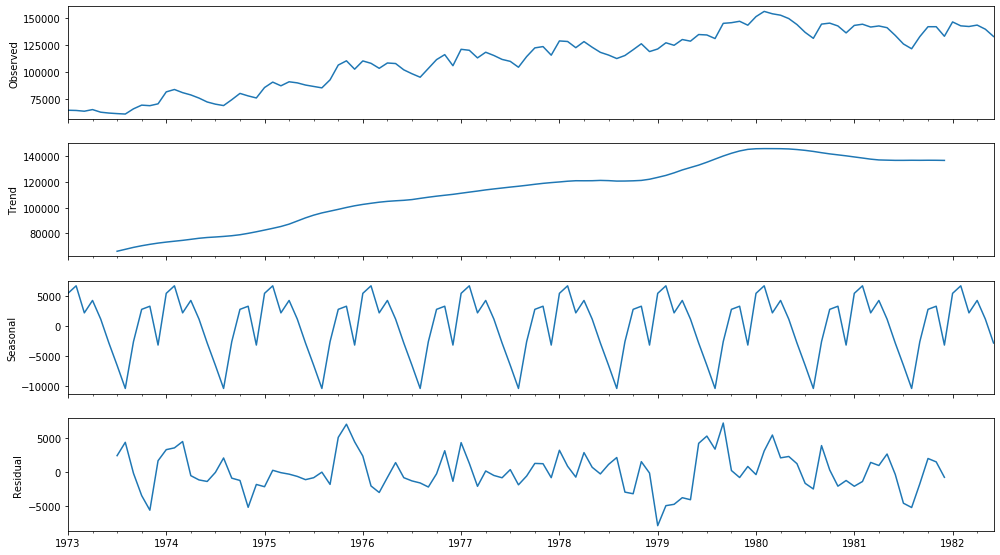

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.riders, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [119]:
sample_data = sample_monthly[::31]

<Figure size 576x432 with 0 Axes>

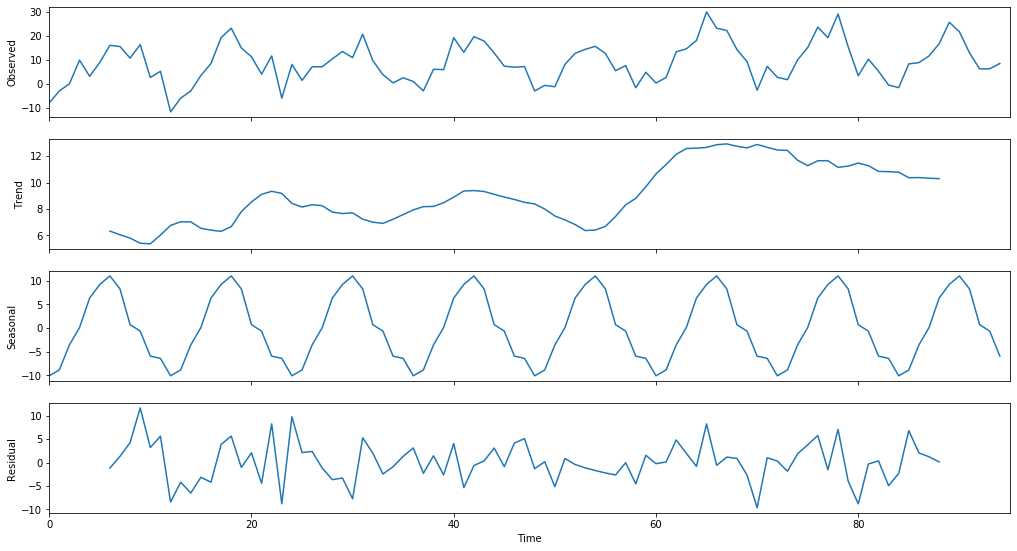

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sample_data.values, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [128]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

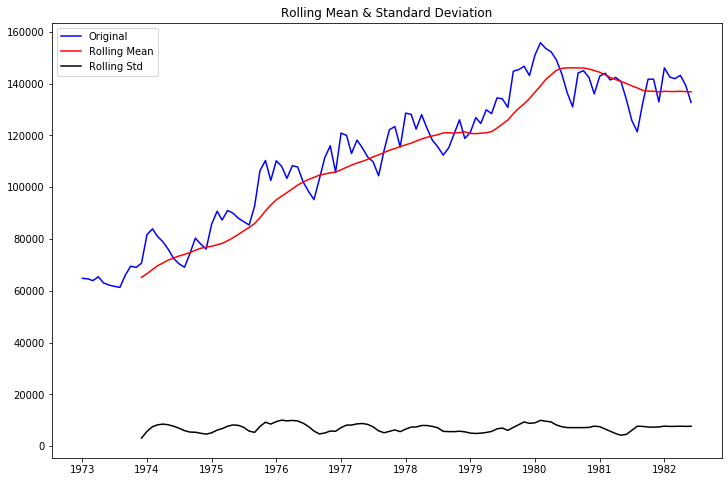

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [129]:
test_stationarity(df.riders)

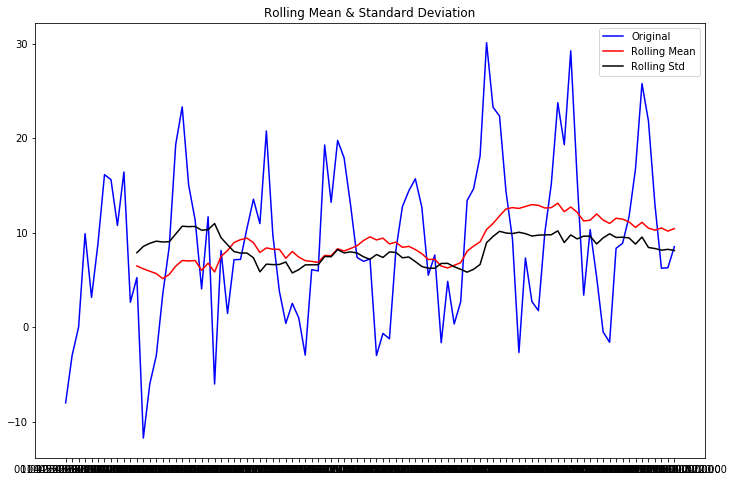

Results of Dickey-Fuller Test:
Test Statistic                 -1.767121
p-value                         0.396903
#Lags Used                     10.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [133]:
test_stationarity(sample_data)

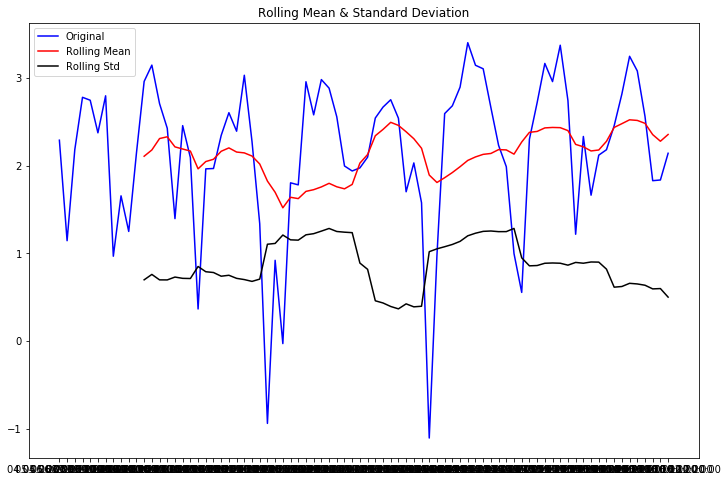

Results of Dickey-Fuller Test:
Test Statistic                -5.966434e+00
p-value                        1.982696e-07
#Lags Used                     4.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


In [135]:
sample_data_log= sample_data.apply(lambda x: np.log(x))  
test_stationarity(sample_data_log.dropna())

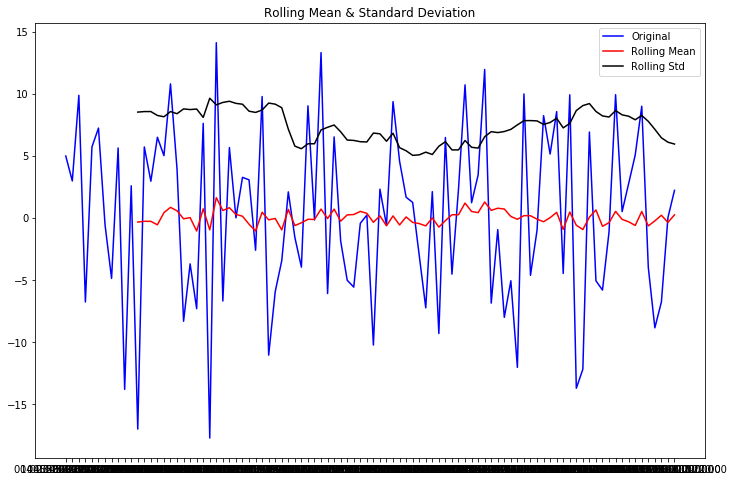

Results of Dickey-Fuller Test:
Test Statistic                -6.830497e+00
p-value                        1.899157e-09
#Lags Used                     1.000000e+01
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


In [136]:

sample_data_firstdf = sample_data - sample_data.shift(1)  
test_stationarity(sample_data_firstdf.dropna(inplace=False))


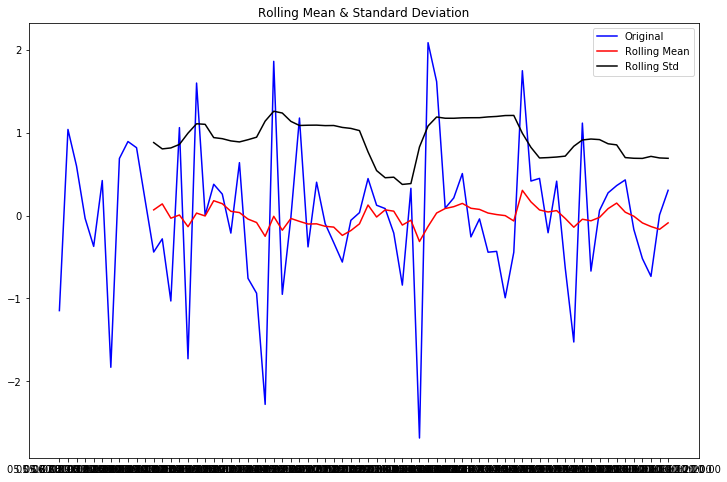

Results of Dickey-Fuller Test:
Test Statistic                 -5.492983
p-value                         0.000002
#Lags Used                      7.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [137]:
sample_data_first_logdf = sample_data_log - sample_data_log.shift(1)  
test_stationarity(sample_data_first_logdf.dropna(inplace=False))

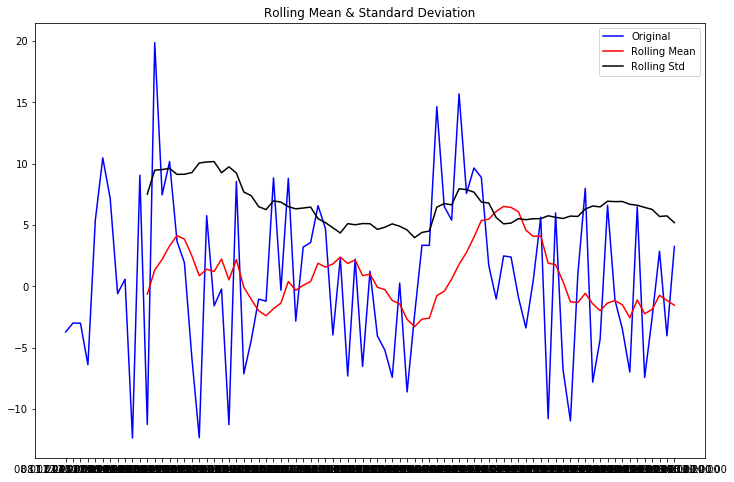

Results of Dickey-Fuller Test:
Test Statistic                 -4.382528
p-value                         0.000319
#Lags Used                     11.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [138]:
sample_dt_seasonal_diff = sample_data - sample_data.shift(12)  
test_stationarity(sample_dt_seasonal_diff.dropna(inplace=False))

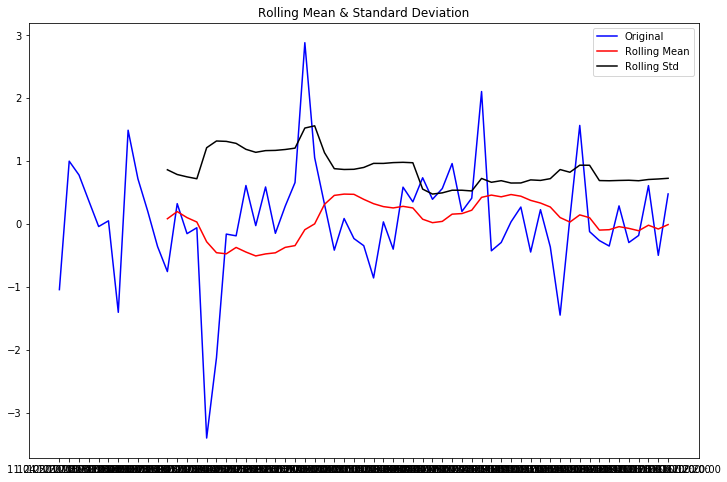

Results of Dickey-Fuller Test:
Test Statistic                -6.026385e+00
p-value                        1.452577e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.200000e+01
Critical Value (1%)           -3.540523e+00
Critical Value (5%)           -2.909427e+00
Critical Value (10%)          -2.592314e+00
dtype: float64


In [139]:
sample_dt_seasonal_logdiff = sample_data_log - sample_data_log.shift(12)  
test_stationarity(sample_dt_seasonal_logdiff.dropna(inplace=False))

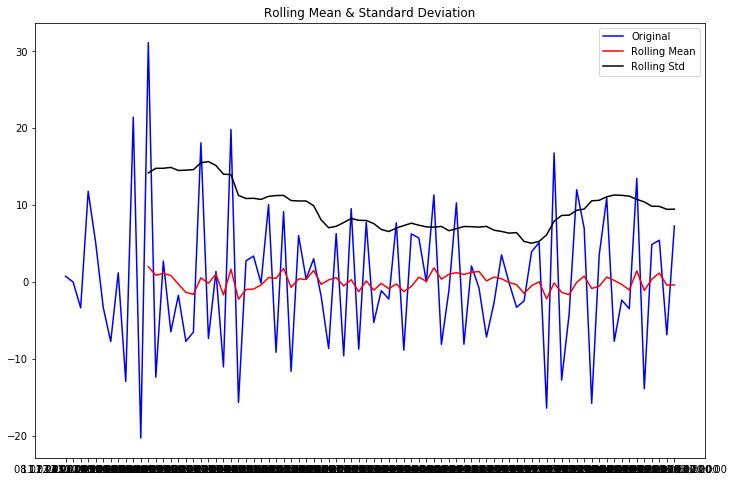

Results of Dickey-Fuller Test:
Test Statistic                 -4.291454
p-value                         0.000460
#Lags Used                     12.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [141]:
sample_dt_seas_first_df = sample_data_firstdf - sample_data_firstdf.shift(12)
test_stationarity(sample_dt_seas_first_df.dropna(inplace=False))

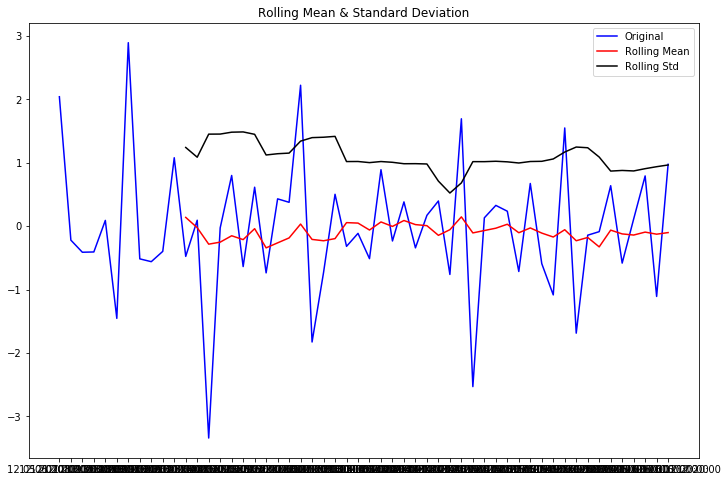

Results of Dickey-Fuller Test:
Test Statistic                 -5.079670
p-value                         0.000015
#Lags Used                      7.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


In [142]:
sample_dt_seas_first_logdf = sample_data_first_logdf - sample_data_first_logdf.shift(12)
test_stationarity(sample_dt_seas_first_logdf.dropna(inplace=False))

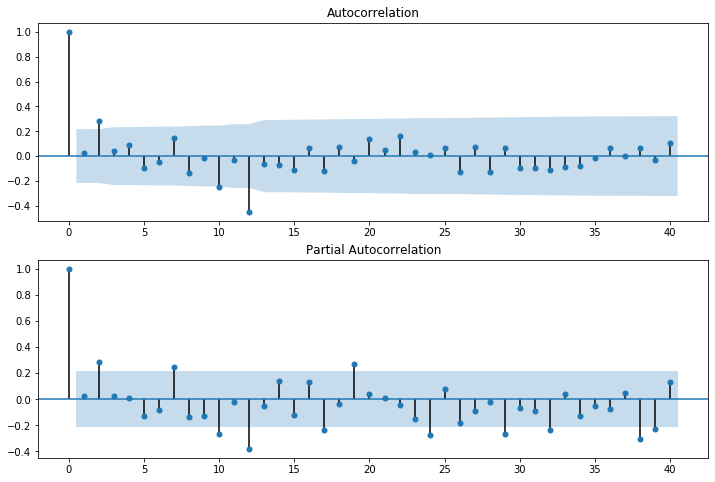

In [143]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sample_dt_seasonal_diff.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sample_dt_seasonal_diff.iloc[13:], lags=40, ax=ax2)

In [145]:
mod = sm.tsa.statespace.SARIMAX(sample_data, trend='n', order=(0,1,0), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           T (degC)   No. Observations:                   95
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -280.053
Date:                            Wed, 05 Feb 2020   AIC                            564.105
Time:                                    11:48:41   BIC                            568.918
Sample:                                         0   HQIC                           566.038
                                             - 95                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9991     57.873     -0.017      0.986    -114.428     112.429
sigma2        40.1332   2321.337   

In [147]:
mod = sm.tsa.statespace.SARIMAX(sample_data, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           T (degC)   No. Observations:                   95
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -279.464
Date:                            Wed, 05 Feb 2020   AIC                            564.927
Time:                                    11:49:37   BIC                            572.147
Sample:                                         0   HQIC                           567.826
                                             - 95                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1380      0.202     -0.683      0.495      -0.534       0.258
ma.S.L12      -0.9993    107.429   

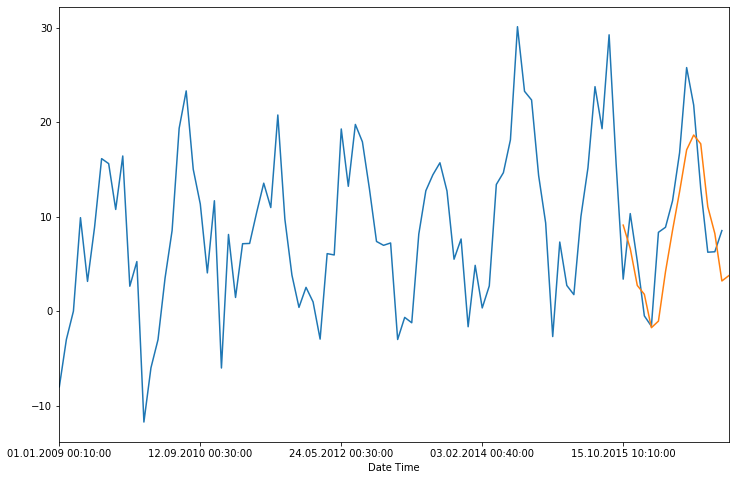

In [149]:
sample_forecast = results.predict(start = 80, end= 95, dynamic= True)  
sample_data.plot(figsize=(12, 8)) 
sample_forecast.plot(figsize=(12, 8))
plt.savefig('ts_df_predict.png', bbox_inches='tight')